In [1]:
# Standard library imports
import os
import json
import sys
import re
import concurrent.futures
from typing import List, Dict, Any, Tuple, TypedDict, Annotated, Optional

# Third-party imports
import boto3
import fitz
import requests
from bs4 import BeautifulSoup
from opensearchpy import OpenSearch, RequestsHttpConnection
from pydantic import BaseModel, Field, ValidationError
from IPython.display import Image

# LangChain core imports
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage, SystemMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnableParallel, RunnablePassthrough, RunnableLambda
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
from langchain_core.tools import tool
from langchain.schema import BaseRetriever, Document

# LangGraph imports
from langgraph.graph import StateGraph, add_messages, START, END
from langgraph.prebuilt import ToolNode, tools_condition

# LangChain AWS imports
from langchain_aws import ChatBedrockConverse, BedrockEmbeddings

# LangChain experimental imports
from langchain_experimental.tools.python.tool import PythonAstREPLTool

# LangChain community imports
from langchain_community.tools.tavily_search import TavilySearchResults

# Operator imports
from operator import itemgetter



In [2]:
def visualize(graph):
    display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
    )

In [3]:
class State(TypedDict):
    messages: Annotated[List, add_messages]
    tools: List[Dict[str, Any]]


In [4]:
bedrock_client = boto3.client(
    service_name='bedrock-runtime',
    region_name='us-east-1'  # replace with your region
)
llm = ChatBedrockConverse(
    model_id="anthropic.claude-3-sonnet-20240229-v1:0",
    client=bedrock_client,
    temperature=0.7,
    max_tokens=2000
)

In [5]:
# Define your state
class State(TypedDict):
    messages: Annotated[List, add_messages]
    tools_list: List  # Store the tools

# Set up API key
os.environ["TAVILY_API_KEY"] = "xxxx"
search_tool = TavilySearchResults()


@tool
def python_code_interpreter(code: str):
    """Call to execute python code."""
    return PythonAstREPLTool().invoke(code)

@tool
def search_func(question: str):
    """Search the web for information using Tavily search engine"""
    # Use the tool to search
    search_results = search_tool.invoke(question)
    return search_results

# Create a list of tools
tools = [search_func, python_code_interpreter]



# Create the tool node
tool_node = ToolNode(tools)



In [6]:
model_with_tools = llm.bind_tools(tools)


In [7]:
model_with_tools.invoke("처음 5개의 소수를 출력하는 python code 를 작성해줘").tool_calls


[{'name': 'python_code_interpreter',
  'args': {'code': 'def is_prime(n):\n    if n < 2:\n        return False\n    for i in range(2, int(n**0.5) + 1):\n        if n % i == 0:\n            return False\n    return True\n\nprimes = []\nn = 2\nwhile len(primes) < 5:\n    if is_prime(n):\n        primes.append(n)\n    n += 1\n\nprint(primes)'},
  'id': 'tooluse_mQf2NHdXQ8-aCOt1sNOm4Q',
  'type': 'tool_call'}]

In [8]:
tool_node.invoke(
    {
        "messages": [
            model_with_tools.invoke(
                "llm에 대하여 서치해줘"
            )
        ]
    }
)


{'messages': [ToolMessage(content='[{"title": "Large language model - Wikipedia", "url": "https://en.wikipedia.org/wiki/Large_language_model", "content": "A large language model (LLM) is a type of machine learning model designed for natural language processing tasks such as language generation. LLMs are language models with many parameters, and are trained with self-supervised learning on a vast amount of text.", "score": 0.95176035}, {"title": "What are Large Language Models? | A Comprehensive LLMs Guide", "url": "https://www.elastic.co/what-is/large-language-models", "content": "What are large language models (LLMs)?\\nExperiment with RAG using AI Playground\\nLarge language model definition\\nA large language model (LLM) is a deep learning algorithm that can perform a variety of natural language processing (NLP) tasks. Large language models use transformer models and are trained using massive datasets — hence, large. This enables them to recognize, translate, predict, or generate te

In [9]:
from langgraph.graph import StateGraph, MessagesState, START, END


# LLM 모델을 사용하여 메시지 처리 및 응답 생성, 도구 호출이 포함된 응답 반환
def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


In [10]:
workflow = StateGraph(MessagesState)

# 에이전트와 도구 노드 정의 및 워크플로우 그래프에 추가
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

In [11]:
workflow.add_edge(START, "agent")

# 에이전트 노드에서 조건부 분기 설정, 도구 노드 또는 종료 지점으로 연결
workflow.add_conditional_edges("agent", tools_condition)


In [12]:
workflow.add_edge("tools", "agent")

# 에이전트 노드에서 종료 지점으로 연결
workflow.add_edge("agent", END)

In [13]:
app = workflow.compile()


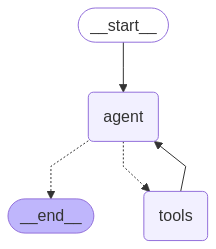

In [14]:
visualize(app)


In [15]:
for chunk in app.stream(
    {"messages": [("human", "처음 5개의 소수를 출력하는 python code 를 작성해줘")]},
    stream_mode="values",
):
    # 마지막 메시지 출력
    chunk["messages"][-1].pretty_print()


================================ Human Message =================================

처음 5개의 소수를 출력하는 python code 를 작성해줘
================================== Ai Message ==================================

[{'type': 'text', 'text': '여기 처음 5개의 소수를 출력하는 Python 코드입니다:'}, {'type': 'tool_use', 'name': 'python_code_interpreter', 'input': {'code': 'def is_prime(n):\n    if n < 2:\n        return False\n    for i in range(2, int(n**0.5) + 1):\n        if n % i == 0:\n            return False\n    return True\n\nprimes = []\nnum = 2\nwhile len(primes) < 5:\n    if is_prime(num):\n        primes.append(num)\n    num += 1\n\nprint(primes)'}, 'id': 'tooluse_WeN0lJ8fSquYn62BXCFqPQ'}]
Tool Calls:
  python_code_interpreter (tooluse_WeN0lJ8fSquYn62BXCFqPQ)
 Call ID: tooluse_WeN0lJ8fSquYn62BXCFqPQ
  Args:
    code: def is_prime(n):
    if n < 2:
        return False
    for i in range(2, int(n**0.5) + 1):
        if n % i == 0:
            return False
    return True

primes = []
num = 2
while len(primes) < 

In [ ]:
# 검색 질문 수행
for chunk in app.stream(
    {"messages": [("human", "ai에 대해 조사해줘")]},
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()


================================ Human Message =================================

ai에 대해 조사해줘
================================== Ai Message ==================================

[{'type': 'text', 'text': '알겠습니다. AI에 대한 정보를 찾아보겠습니다.'}, {'type': 'tool_use', 'name': 'search_func', 'input': {'question': 'What is AI?'}, 'id': 'tooluse_PTvm2-YyTU-LEIB-_prbXw'}]
Tool Calls:
  search_func (tooluse_PTvm2-YyTU-LEIB-_prbXw)
 Call ID: tooluse_PTvm2-YyTU-LEIB-_prbXw
  Args:
    question: What is AI?
================================= Tool Message =================================
Name: search_func

[{"title": "What Is Artificial Intelligence (AI)? | Google Cloud", "url": "https://cloud.google.com/learn/what-is-artificial-intelligence", "content": "What is Artificial Intelligence (AI)?\nArtificial intelligence (AI) is a set of technologies that enable computers to perform a variety of advanced functions, including the ability to see, understand and translate spoken and written language, analyze data, m

In [ ]:

# 도구 호출이 필요 없는 질문 수행
for chunk in app.stream(
    {"messages": [("human", "안녕? 반가워")]},
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()
